In [11]:
#https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [12]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY", start="2018-01-01").reset_index()
df_full.to_csv('INFY.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,8.135,8.195,8.115,8.145,7.352555,12298200
1,2018-01-03,8.120,8.135,8.050,8.075,7.289364,10250800
2,2018-01-04,8.100,8.100,8.010,8.025,7.244229,16272000
3,2018-01-05,8.085,8.190,8.075,8.175,7.379634,9813600
4,2018-01-08,8.190,8.260,8.170,8.240,7.438310,11198200


In [13]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        #-------------------------- 
        # Giai đoạn Định nghĩa
        #-------------------------- 
        #Kích cỡ của Size Q-Learning
        self.state_size = state_size
        #Kích cỡ Window
        self.window_size = window_size
        #Kích cỡ nữa Window
        self.half_window = window_size // 2
        #Giá trị mà ta quan tâm ở đây thường quan tâm đến Closing Price
        self.trend = trend
        #Bước nhảy
        self.skip = skip
        #Ví trong bài toán này chỉ có 3 hành động Buy/Sell/Hold --> action_size = 3
        self.action_size = 3
        self.batch_size = batch_size
        #Hàng đọi có chiều dài tối đa 1000 phần tử
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        #Các hằng số của mô hình
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        
        #-------------------------- 
        # Giai đoạn Deep Q-learning
        #-------------------------- 
        # 1. Pha chạy các thư viện tensorflow DQN
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        # 2. Input
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        # 3. Output
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        # 4. Khởi tạo layer với hàm activtion là relu
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        # 5. Hàm chi phí trong DQN
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # 6. Tối ưu hàm chi phí
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        # 7. Đưa các biến trong phiên làm việc của tensorflow DQN lên toàn cục
        self.sess.run(tf.global_variables_initializer())
        #-------------------------- 
    
    #Hàm chọn hành động giai đoạn đầu có thể là giá trị ngẫu nhiên tới một khoảng thời gian nào đó sẽ lấy hàm argmax để học
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        #Khởi tạo mini_batch là []
        mini_batch = []
        #Xem chiều dài của memory
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        #Truyền State và Action
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        #self: chính là chính bản thân của class
        for i in range(iterations):
            #Tổng lợi nhuận ban đầu
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                #Hành động mua và bán
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                
                #Xem tiền đã bị giảm/tăng bao nhiêu phần sau mỗi lần giao dịch
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
              
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))

### Các khái niệm:


- Khi dữ liệu quá lớn ta không thể đưa ra đưa vào một epoch cho nó học một lần được mà phải chia ra làm nhiều batch_size nhỏ
- Epoch: Một lần đưa dữ liệu vào mạng Neural network thì được gọi là một Epoch
- Batch_size: Số lượng phần tử học tại mỗi Epoch
- Ví dụ chúng ta có tập dữ liệu có 20,000 mẫu, batch size là 500, vậy chúng ta cần 40 lần lặp (iteration) để hoàn thành 1 epoch.
- Vậy bài toán chúng ta là 863 mẫu, batchsize là 32, vậy chúng ta cần 26 iterations

In [15]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
iteration_size = len(df_full)//batch_size
iteration_size = iteration_size*10
agent.train(iterations = iteration_size, checkpoint = 10, initial_money = initial_money)
#Một Epoch được tính là khi chúng ta đưa tất cả dữ liệu vào mạng neural network 1 lần

c:\users\minh nhut\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 43.440000.3, cost: 0.089985, total money: 5285.459991
epoch: 20, total rewards: 97.005000.3, cost: 0.071959, total money: 5662.729994
epoch: 30, total rewards: 125.900001.3, cost: 0.050308, total money: 6379.579995
epoch: 40, total rewards: 134.395000.3, cost: 0.038243, total money: 6803.374992
epoch: 50, total rewards: 113.825000.3, cost: 0.024386, total money: 7434.404995
epoch: 60, total rewards: 99.929998.3, cost: 0.017532, total money: 7808.239995
epoch: 70, total rewards: 158.580000.3, cost: 0.012871, total money: 8127.819996
epoch: 80, total rewards: 145.284997.3, cost: 0.011277, total money: 8227.834992
epoch: 90, total rewards: 172.544996.3, cost: 0.009325, total money: 8351.254992
epoch: 100, total rewards: 214.524995.3, cost: 0.007622, total money: 8505.854989
epoch: 110, total rewards: 226.499999.3, cost: 0.006688, total money: 8615.919994
epoch: 120, total rewards: 237.214996.3, cost: 0.006363, total money: 8595.014992
epoch: 130, total rewards: 2

In [16]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 8.960000, total balance 9991.040000
day 14, sell 1 unit at price 9.225000, investment 2.957593 %, total balance 10000.265000,
day 18: buy 1 unit at price 9.275000, total balance 9990.990001
day 19: buy 1 unit at price 9.125000, total balance 9981.865001
day 20, sell 1 unit at price 9.005000, investment -2.911046 %, total balance 9990.870001,
day 21, sell 1 unit at price 8.965000, investment -1.753423 %, total balance 9999.835001,
day 23: buy 1 unit at price 8.685000, total balance 9991.150001
day 24, sell 1 unit at price 8.735000, investment 0.575696 %, total balance 9999.885000,
day 25: buy 1 unit at price 8.740000, total balance 9991.145000
day 26, sell 1 unit at price 8.555000, investment -2.116699 %, total balance 9999.700001,
day 27: buy 1 unit at price 8.680000, total balance 9991.020000
day 28, sell 1 unit at price 8.810000, investment 1.497697 %, total balance 9999.830001,
day 29: buy 1 unit at price 8.730000, total balance 9991.100001
day 30, sell 1

day 382: buy 1 unit at price 10.720000, total balance 9992.359998
day 383: buy 1 unit at price 11.400000, total balance 9980.959998
day 387, sell 1 unit at price 11.550000, investment 7.742536 %, total balance 9992.509998,
day 388, sell 1 unit at price 11.390000, investment -0.087713 %, total balance 10003.899999,
day 389: buy 1 unit at price 11.460000, total balance 9992.439999
day 391: buy 1 unit at price 11.460000, total balance 9980.979999
day 392: buy 1 unit at price 11.520000, total balance 9969.459998
day 393, sell 1 unit at price 11.480000, investment 0.174516 %, total balance 9980.939998,
day 394, sell 1 unit at price 11.510000, investment 0.436302 %, total balance 9992.449998,
day 395, sell 1 unit at price 11.420000, investment -0.868059 %, total balance 10003.869998,
day 401: buy 1 unit at price 11.160000, total balance 9992.709998
day 402, sell 1 unit at price 11.250000, investment 0.806453 %, total balance 10003.959998,
day 406: buy 1 unit at price 10.790000, total balance

day 720, sell 1 unit at price 14.540000, investment 59.780213 %, total balance 9601.789996,
day 721, sell 1 unit at price 15.090000, investment 61.736337 %, total balance 9616.879996,
day 722: buy 1 unit at price 14.950000, total balance 9601.929996
day 723: buy 1 unit at price 15.290000, total balance 9586.639997
day 725: buy 1 unit at price 15.280000, total balance 9571.359997
day 728, sell 1 unit at price 14.910000, investment 61.713660 %, total balance 9586.269997,
day 730: buy 1 unit at price 15.530000, total balance 9570.739997
day 732, sell 1 unit at price 14.920000, investment 63.596494 %, total balance 9585.659997,
day 733, sell 1 unit at price 15.220000, investment 65.075920 %, total balance 9600.879997,
day 734: buy 1 unit at price 15.380000, total balance 9585.499997
day 735: buy 1 unit at price 15.410000, total balance 9570.089997
day 738: buy 1 unit at price 15.620000, total balance 9554.469997
day 739: buy 1 unit at price 16.010000, total balance 9538.459997
day 743: buy

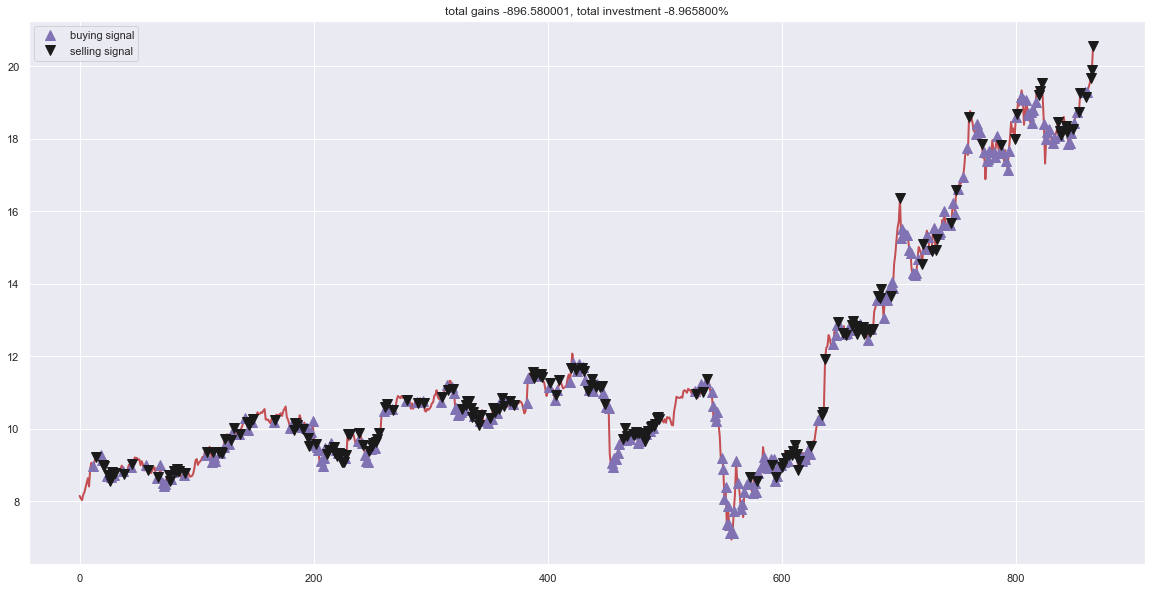

In [17]:
fig = plt.figure(figsize = (20,10))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

868

In [14]:
states_buy

[10,
 24,
 27,
 28,
 31,
 34,
 42,
 49,
 63,
 66,
 72,
 74,
 75,
 81,
 85,
 91,
 94,
 102,
 110,
 117,
 135,
 137,
 138,
 144,
 152,
 161,
 164,
 178,
 181,
 184,
 187,
 194,
 197,
 202,
 204,
 205,
 207,
 209,
 210,
 212,
 213,
 216,
 220,
 225,
 229,
 232,
 235,
 243,
 250,
 253,
 254,
 261,
 264,
 287,
 290,
 304,
 319,
 322,
 323,
 325,
 326,
 327,
 328,
 342,
 343,
 346,
 347,
 349,
 356,
 359,
 371,
 373,
 389,
 400,
 405,
 407,
 408,
 414,
 419,
 424,
 427,
 437,
 438,
 440,
 441,
 449,
 452,
 455,
 457,
 458,
 460,
 462,
 463,
 464,
 474,
 481,
 484,
 491,
 514,
 515,
 537,
 540,
 543,
 546,
 549,
 550,
 552,
 553,
 555,
 557,
 558,
 559,
 560,
 564,
 566,
 569,
 571,
 572,
 579,
 582,
 583,
 587,
 588,
 590,
 596,
 599,
 601,
 602,
 605,
 606,
 609,
 613,
 616,
 618,
 619,
 624,
 625,
 628,
 632,
 640,
 643,
 651,
 656,
 659,
 660,
 663,
 666,
 669,
 672,
 675,
 682,
 685,
 688,
 691,
 694,
 703,
 707,
 709,
 713,
 715,
 716,
 719,
 720,
 724,
 727,
 733,
 736,
 740,
 745,
 74

In [8]:
# a = 863//32
# print(a)

26


In [10]:
# batch_size =32
# iteration_size = len(df_full)//batch_size
# print(iteration_size*10)

270
